In [1]:
# default_exp language_modeling

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics Verbatims - ULMFiT Language Model

> Experiments related to building a LM for survey comments captured in the Tritonlytics survey delivery system

In [3]:
#export
import datetime
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
#hide
print(f'fastai version: {fa2_version}')

fastai version: 2.0.14


In [6]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Language Model

The goal of the language model is to predict the next word.  The idea is simple: an LM learns how English works which can in turn be helpful in predicting sentiment

In [7]:
chunksize = 24000
yyyymmdd = datetime.today().strftime("%Y%m%d")

bptt = 70
bsz = 128 #80
wd = 1e-7

# define tokenization, numericalization, and data parameters (tokeneization, text columns, etc..)
include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

max_vocab = 60000
min_freq = 2

corpus_cols = ['AnswerText']  # ['QuestionText', 'AnswerText']
data_suf = ''                 # '_qst+ans' 

Prepare the data source

In [8]:
train_df = pd.read_csv(LM_PATH/'train.csv', low_memory=False)
valid_df = pd.read_csv(LM_PATH/'test.csv', low_memory=False)

In [9]:
# remove rows where there are nulls in corpus cols
prev_lens = len(train_df), len(valid_df)

train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

print(f'Removed rows: {prev_lens[0]-len(train_df), prev_lens[1] - len(valid_df)}')

Removed rows: (0, 0)


In [10]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [11]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

Using the low-level `Datasets` API

In [12]:
%%time

tfms = [
    attrgetter('text'), 
    Tokenizer.from_df(text_cols=corpus_cols, rules=custom_tok_rules, mark_fields=include_fld_tok), 
    Numericalize(min_freq=min_freq, max_vocab=max_vocab)
]

lm_dsets = Datasets(items=df,
                    tfms=[tfms], 
                    splits=ColSplitter(col='is_valid')(df), 
                    dl_type=LMDataLoader)

len(lm_dsets.train), len(lm_dsets.valid)

CPU times: user 23 s, sys: 16.1 s, total: 39.1 s
Wall time: 54.5 s


(532302, 59145)

In [13]:
t = lm_dsets[0]
type(t[0]), t

(fastai.text.data.TensorText,
 (TensorText([   2,    8,  537,   15,   25, 1946,   12,  404, 3258,   42,   96,  271,
            52, 1143]),))

In [14]:
x = lm_dsets.decode(t); x

('xxbos xxmaj perhaps a more detailed and clear instruction would help first time users',)

In [15]:
lm_dsets.show(x)

xxbos xxmaj perhaps a more detailed and clear instruction would help first time users


In [16]:
%%time
lm_dls = lm_dsets.dataloaders(bs=bsz, seq_len=bptt)

CPU times: user 3min 38s, sys: 3.67 s, total: 3min 42s
Wall time: 3min 40s


Using the mid-level `DataBlock` API

In [17]:
lm_blocks = (TextBlock.from_df(corpus_cols, is_lm=True, 
                               seq_len=bptt, 
                               rules=custom_tok_rules, 
                               mark_fields=include_fld_tok), )

lm_dblock = DataBlock(blocks=lm_blocks, 
                      get_x=ColReader('text'),
                      splitter=ColSplitter(col='is_valid'))

In [18]:
# lm_dblock.summary(df)

In [19]:
%%time
lm_dls = lm_dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 3min 37s, sys: 20.7 s, total: 3min 58s
Wall time: 4min 10s


Save `DataLoaders` and vocab

In [20]:
# save dataloaders
torch.save(lm_dls, LM_PATH/f'data_lm{data_suf}.pkl')

# save vocab for classifiers
pickle.dump(lm_dls.vocab, open(LM_PATH/f'vocab{data_suf}.pkl','wb'))

Let's look at things ...

In [21]:
lm_dls = torch.load(LM_PATH/f'data_lm{data_suf}.pkl')

In [22]:
lm_dls.show_batch(max_n=2)

,text,text_
0,xxbos xxmaj more s parking for xxmaj warren will be more convenient . xxbos xxmaj as a woman i do nt feel safe on campus at all and no one cares about it . i regret going to this school and would not recommend it to anyone . xxbos xxmaj permit options xxbos i would love a delivery system that takes food into dorms xxbos xxmaj travel and xxmaj entertainment,xxmaj more s parking for xxmaj warren will be more convenient . xxbos xxmaj as a woman i do nt feel safe on campus at all and no one cares about it . i regret going to this school and would not recommend it to anyone . xxbos xxmaj permit options xxbos i would love a delivery system that takes food into dorms xxbos xxmaj travel and xxmaj entertainment made
1,"book for my research from another university . xxmaj there was no way to extend the loan , and i ended up having to buy the very expensive book myself . xxbos xxmaj allow the easypark to be updated online ( add money online instead of having to bring it in ) xxbos xxmaj hillcrest feels like an actual city and not an overgrown shopping mall like xxmaj la xxmaj","for my research from another university . xxmaj there was no way to extend the loan , and i ended up having to buy the very expensive book myself . xxbos xxmaj allow the easypark to be updated online ( add money online instead of having to bring it in ) xxbos xxmaj hillcrest feels like an actual city and not an overgrown shopping mall like xxmaj la xxmaj jolla"


In [23]:
print(len(lm_dls.vocab), len(lm_dls.train.vocab), len(lm_dls.valid.vocab))
print(lm_dls.vocab[:10])

32408 32408 32408
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '.']


In [24]:
print(len(lm_dls.train_ds), len(lm_dls.train_ds.vocab))
print(len(lm_dls.valid_ds), len(lm_dls.valid_ds.vocab))

532302 32408
59145 32408


In [25]:
batch = next(iter(lm_dls.train))
print(batch[0].size()), print(batch[1].size())

torch.Size([128, 70])
torch.Size([128, 70])


(None, None)

In [26]:
' '.join([ lm_dls.vocab[idx] for idx in batch[0][0,:] ])

'xxbos xxmaj very quick internet with how many people operate in the libraries . xxbos i received personal attention to our problem in our department . xxmaj tim xxmaj jasko and xxmaj nathan xxmaj cho frequently communicated with me and our department suggesting effective solutions to our immediate problems . i was impressed with their professionalism and i felt a personal investment on their part to find solutions for our'

... and backwards

In [27]:
lm_dls_bwd = torch.load(LM_PATH/f'data_lm{data_suf}.pkl')

In [28]:
lm_dls_bwd.tfms.add(Transform(lambda nums: nums.flip(0)))

In [29]:
lm_dls_bwd.tfms

Pipeline: ColReader -- {'cols': 'text', 'pref': '', 'suff': '', 'label_delim': None} -> Tokenizer -> Numericalize -> <lambda>

In [30]:
lm_dls_bwd.show_batch(max_n=2)

,text,text_
0,use to easy very and good is app the xxmaj xxbos . job great a does herrera xxmaj frank xxmaj . them help to there 're you that know to need they xxmaj . there are police the that scared are people when times at friendlier bit little a be xxmaj xxbos ! staff approachable and helpful really xxmaj xxbos ! books for rates return better xxbos s to spots,to easy very and good is app the xxmaj xxbos . job great a does herrera xxmaj frank xxmaj . them help to there 're you that know to need they xxmaj . there are police the that scared are people when times at friendlier bit little a be xxmaj xxbos ! staff approachable and helpful really xxmaj xxbos ! books for rates return better xxbos s to spots b
1,martinez xxmaj justin xxmaj \n r \ hdh xxup - mcerlain kim xxmaj \n r \ hdh xxup - petrus xxmaj julie xxmaj \n r \ hdh xxup - falomir xxmaj ryan xxmaj \n r \ hdh xxup - grenard xxmaj kelly xxmaj \n r \ hdh xxup - smith xxmaj norma xxmaj \n r \ alumni xxmaj - wells xxmaj madison xxmaj \n r \ hdh xxup - bermudez,xxmaj justin xxmaj \n r \ hdh xxup - mcerlain kim xxmaj \n r \ hdh xxup - petrus xxmaj julie xxmaj \n r \ hdh xxup - falomir xxmaj ryan xxmaj \n r \ hdh xxup - grenard xxmaj kelly xxmaj \n r \ hdh xxup - smith xxmaj norma xxmaj \n r \ alumni xxmaj - wells xxmaj madison xxmaj \n r \ hdh xxup - bermudez xxmaj


### Configure a forward or backwards run

In [31]:
backwards = False

m_pre = 'bwd_' if (backwards) else 'fwd_'

### Build the LanguageModel (baseline)

Our Language Model (LM) is composed of a backbone and a custom head.  The backbone is initialized with the weights of an LM trained on a larger corpus, [Wikitext 103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) and the custom head is a linear classifier.  The vocabulary of the two datasets are slightly different, so when loading the weights, we take care to put the embedding weights at the right place, and we randomly initiliaze the embeddings for words in our vocabulary that weren't in the wikitext-103 vocabulary of our pretrained model.

The pretrained model will be downloaded on first use. We also use **Mixed Precision** Trianing, which enables us to use a higher batch size by training part of our model in FP16 precision, and also speeds up trqining by a factor 2 to 3 on modern GPUs.

**bptt** (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

We setup the **dropouts** for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer (the `Learner` object is frozen by default)

We also keep track of the *accuracy* metric.

In [32]:
lm_dls = torch.load(LM_PATH/f'data_lm{data_suf}.pkl')

def reverse_text(nums): return nums.flip(0)
if (backwards): lm_dls.tfms.add(Transform(reverse_text))

In [33]:
# try: learn.purge(); learn = None; gc.collect(); torch.cuda.empty_cache()
# except: pass

In [34]:
best_model = SaveModelCallback(monitor='accuracy', comp=np.greater, fname=f'{m_pre}lm_bestmodel{data_suf}')

learn = language_model_learner(lm_dls,
                               arch=AWD_LSTM, 
                               backwards=backwards,
                               drop_mult=0.7,
                               opt_func=partial(Adam, wd=wd),
                               moms=(0.8, 0.7, 0.8),
                               path=LM_PATH,
                               metrics=[accuracy, Perplexity()]).to_fp16()

# learn.true_wd = True

In [35]:
learn.summary()

SequentialRNN (Input shape: ['128 x 70'])
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           128 x 70 x 400       0          False     
________________________________________________________________
RNNDropout           128 x 70 x 1152      0          False     
________________________________________________________________
RNNDropout           128 x 70 x 1152      0          False     
________________________________________________________________
Linear               128 x 70 x 32408     12,995,608 True      
________________________________________________________________
RNNDropout           128 x 70 x 400       0          False     
________________________________________________________________

Total params: 12,995,608
Total trainable params: 12,995,608
Total non-trainable params: 0

Optimizer used: functools.partial(<function Adam at 0x7f205130eef0>, wd=1e-07)
Loss function: FlattenedLoss of CrossEntropyLoss()

Model frozen up to paramet

In [36]:
# best_model_path = LM_PATH/f'models/{m_pre}lm_bestmodel{data_suf}*'
# !rm {best_model_path}

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.03019951656460762)

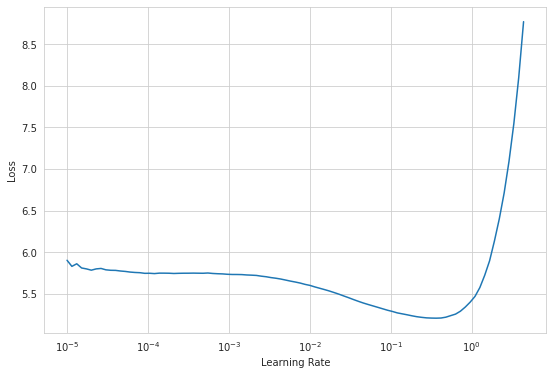

In [37]:
learn.lr_find(start_lr=1e-5, end_lr=1e+1)

In [38]:
lr = 3e-2

In [39]:
%%time
learn.fit_one_cycle(1, lr, cbs=[best_model])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.073090,3.747765,0.299773,42.426147,13:53


Better model found at epoch 0 with accuracy value: 0.2997727692127228.
CPU times: user 13min 49s, sys: 4.71 s, total: 13min 54s
Wall time: 13min 53s


In [40]:
learn.save(f'{m_pre}lm_last_ft{data_suf}')
# best model is loaded at conclusion of previous fit #learn = learn.load(f'{l_pre}lm_last_ft{exp_suffix}')

Path('data/lm/models/fwd_lm_last_ft.pth')

unfreeze and train some more

In [41]:
learn.load(f'{m_pre}lm_last_ft{data_suf}')

SuggestedLRs(lr_min=0.0008317637257277966, lr_steep=0.0006025595939718187)

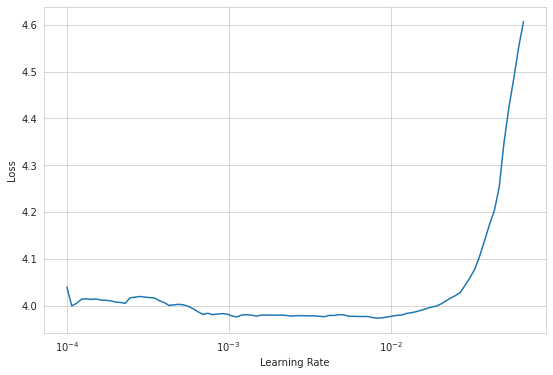

In [42]:
learn.unfreeze()
learn.lr_find(start_lr=1e-3/10, end_lr=1e-2*10)

In [43]:
lr = 4e-3

In [44]:
%%time
learn.fit_one_cycle(15, lr_max=slice(lr/10, lr), cbs=[best_model])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.817059,3.628915,0.313470,37.671932,15:12
1,3.713429,3.538882,0.323474,34.428398,15:14
2,3.638062,3.477099,0.330150,32.365692,15:11
3,3.554389,3.429190,0.335835,30.851648,15:13
4,3.504758,3.397214,0.339364,29.880749,15:14
5,3.456166,3.375092,0.342190,29.226967,15:15
6,3.423495,3.359746,0.343825,28.781872,15:19
7,3.394121,3.347323,0.345716,28.426533,15:10
8,3.368732,3.337389,0.346813,28.145536,15:12
9,3.339001,3.330578,0.347656,27.954491,15:10


Better model found at epoch 0 with accuracy value: 0.3134704828262329.
Better model found at epoch 1 with accuracy value: 0.3234744668006897.
Better model found at epoch 2 with accuracy value: 0.33014991879463196.
Better model found at epoch 3 with accuracy value: 0.3358348309993744.
Better model found at epoch 4 with accuracy value: 0.339364230632782.
Better model found at epoch 5 with accuracy value: 0.3421899378299713.
Better model found at epoch 6 with accuracy value: 0.34382474422454834.
Better model found at epoch 7 with accuracy value: 0.3457162082195282.
Better model found at epoch 8 with accuracy value: 0.34681281447410583.
Better model found at epoch 9 with accuracy value: 0.34765589237213135.
Better model found at epoch 10 with accuracy value: 0.34856289625167847.
Better model found at epoch 11 with accuracy value: 0.3490394949913025.
Better model found at epoch 12 with accuracy value: 0.34948062896728516.
Better model found at epoch 13 with accuracy value: 0.349526047706604

Save the model and encoder separately

In [45]:
learn.save(f'{m_pre}lm{data_suf}')

Path('data/lm/models/fwd_lm.pth')

In [46]:
learn.save_encoder(f'{m_pre}lm_enc{data_suf}')

Export the learner for future use

In [47]:
learn.export(fname=f'{m_pre}export_lm{data_suf}.pkl')

Then we can have a look at the results

In [48]:
learn = learn.load(f'{m_pre}lm_bestmodel{data_suf}')

In [49]:
learn.validate() # ... returns [loss, accuracy, perplexity]

# 08/27/2019 Answer Only (fwd): acc=0.3485 | loss=3.328849
#                        (bwd): acc=0.3828 | loss=3.3445714

# 02/21/2020 Answer Only (fwd) [3.318399429321289,0.3496691584587097,27.616113662719727]
#                        (bwd) [3.408270835876465,0.37589603662490845,30.212955474853516]

# 05/01/2020 Answer Only (fwd) [3.353671073913574,0.34449684619903564,28.607561111450195]
#                        (bwd) [3.4699654579162598,0.36656343936920166,32.1356315612793]

# 09/21/2020 Answer Only (fwd) [3.3201332092285156,0.3495948910713196,27.66403579711914]
#                        (bwd) ??? - significantly better after adding "backwards=True" to Learner

(#3) [3.3201332092285156,0.3495948910713196,27.66403579711914]

In [50]:
learn.show_results()

,input,target,pred
0,"xxbos xxmaj there continues to be transitions in terms of how the teams are organized , turnover of staff , and it leads to inconsistency and the need to revisit expectations and service delivery . xxmaj perhaps this will be the state of affairs until we fully transition to xxup uc xxmaj path , but it is frustrating that we continue to have to meet with leadership and revisit this","xxmaj there continues to be transitions in terms of how the teams are organized , turnover of staff , and it leads to inconsistency and the need to revisit expectations and service delivery . xxmaj perhaps this will be the state of affairs until we fully transition to xxup uc xxmaj path , but it is frustrating that we continue to have to meet with leadership and revisit this topic","xxmaj the is to be a in the of compensation to xxmaj are managed and and , staff , and the 's to a in lack lack to be and . implement . . xxmaj there there is be a case of the 's the are understand to xxmaj ucpath xxmaj path . but it is not to we are to have to wait with the to see processes process"
1,"hard to find parking xxbos i think that the music on the 2nd and 1st floor should be the same xxbos xxmaj the accessibility of a variety of food items . xxbos xxmaj keep working on systems that can tell where the parking is . xxmaj is it possible to take parking availability into account when scheduling classes ? xxbos xxmaj have a clearer website on information , and be","to find parking xxbos i think that the music on the 2nd and 1st floor should be the same xxbos xxmaj the accessibility of a variety of food items . xxbos xxmaj keep working on systems that can tell where the parking is . xxmaj is it possible to take parking availability into account when scheduling classes ? xxbos xxmaj have a clearer website on information , and be more",to find parking . xxmaj like the the xxmaj department the shuttle floor 8th floors is be more same as xxmaj the staff of the variety of food options . xxbos xxmaj the up on the that are be you the campus lots going xxmaj it it possible to have a spots for the for there a ? xxbos xxmaj the more better way for how about especially more more
2,marsha xxmaj marion is an outstanding ambassador to xxup ucr and has been highly instrumental in helping new managers in xxup hr get up to speed quickly on the department and campus culture . xxbos xxmaj student xxmaj staff are more or less trained in how they can be of assistance to their student peers . xxbos xxmaj pets friendly xxbos xxmaj more xxmaj social events less cultural events xxbos,xxmaj marion is an outstanding ambassador to xxup ucr and has been highly instrumental in helping new managers in xxup hr get up to speed quickly on the department and campus culture . xxbos xxmaj student xxmaj staff are more or less trained in how they can be of assistance to their student peers . xxbos xxmaj pets friendly xxbos xxmaj more xxmaj social events less cultural events xxbos xxmaj,"xxmaj xxunk . a excellent trainer for xxup uc . is been a supportive in helping us employees and the xxunk to promoted to date and and a new 's the . . xxbos xxmaj the xxmaj life xxbos very than less helpful in their to treat help trained service . students customers staff . xxmaj xxmaj the , xxbos xxmaj the parking parking xxmaj xxbos xxbos xxbos xxbos xxmaj"
3,"expensive and there are fewer menu items at some of the places in the xxup hub . xxmaj crafted in the xxup hub is very expensive for a sandwich , especially compared to xxmaj subway that could be customized to whatever you want on the sandwich . xxmaj there should be daily or weekly special items that rotate so that there is more variety xxbos nothing xxbos xxmaj nice variety","and there are fewer menu items at some of the places in the xxup hub . xxmaj crafted in the xxup hub is very expensive for a sandwich , especially compared to xxmaj subway that could be customized to whatever you want on the sandwich . xxmaj there should be daily or

In [51]:
# interp = Interpretation.from_learner(learn) # .. kernel dies at about here: 31.18% [53/170 02:21<05:12]

In [52]:
# interp.plot_top_losses(5)

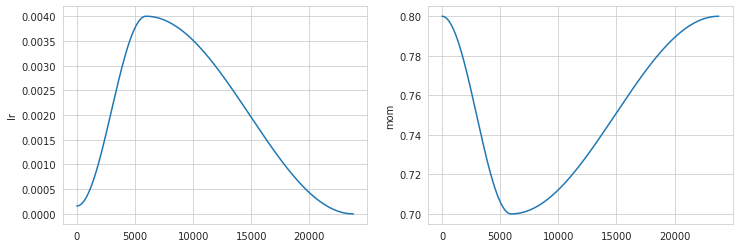

In [53]:
learn.recorder.plot_sched()

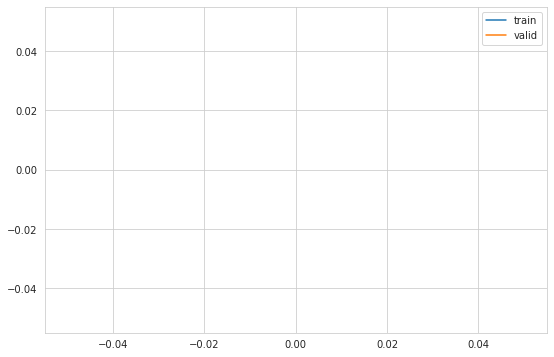

In [54]:
learn.recorder.plot_loss()

#### Inference time (new in 1.40)  
See: https://docs.fast.ai/tutorial.inference.html#Language-modelling

In [55]:
backwards = False
data_suf = ''
m_pre = 'bwd_' if (backwards) else 'fwd_'

inf_learn = load_learner(fname=LM_PATH/f'{m_pre}export_lm{data_suf}.pkl', cpu=True)

In [56]:
inf_learn.predict('The library needs to', n_words=40)

'The library needs to consider adding TLC to the computer section / area . i am amazed at the lack of ability to get more reasonably priced textbooks . If the library refuses to help this issue by hiring many Imprints'

In [57]:
inf_learn.predict('The best thing about parking is', n_words=40)

'The best thing about parking is that they took away painting of parking lot 68 but do i think it is fine since it was grass existing and places that they touched on using sours . Need more lots to park .'

In [58]:
inf_learn.predict('The worse thing about parking is', n_words=40)

'The worse thing about parking is parking on campus . i have a solution to my problem which is an airport issue so hence paying possibilities compared to those that already park on campus . The lines in the gym can get very long'

## Getting document vectors from LM

In [59]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype=TASK_LM_DTYPES, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['AnswerText']  # ['QuestionText', 'AnswerText']

591447 11612


In [60]:
backwards = False
m_pre = 'bwd_' if backwards else 'fwd_'
data_suf = ''

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:1


In [61]:
# inf_learn = None; gc.collect()

inf_learn = load_learner(fname=LM_PATH/f'{m_pre}export_lm{data_suf}.pkl', cpu=False)
inf_learn.model = inf_learn.model.to(device)
inf_learn.model = inf_learn.model.eval()

### Predict by batch

In [62]:
lm_vocab = pickle.load(open(LM_PATH/f'vocab{data_suf}.pkl','rb'))

In [63]:
tfms = [
    attrgetter('text'), 
    Tokenizer.from_df(text_cols=corpus_cols, rules=custom_tok_rules, mark_fields=include_fld_tok), 
    Numericalize(vocab=lm_vocab)
]

test_ds = Datasets(items=inf_df, tfms=[tfms], dl_type=SortedDL)

# note: must include shuffle_train=False or it will drop the last batch when iterating!!!
test_dls = test_ds.dataloaders(bs=64, seq_len=bptt, shuffle_train=False,
                               before_batch=partial(pad_input, pad_first=False))

if (backwards): test_dls.tfms.add(Transform(lambda nums: nums.flip(0)))

# use the test_dls.train dataloader for batch inference!
inf_dl = test_dls.train

In [64]:
print((
    f'inf_df items: {len(inf_df)} | test_dl items: {inf_dl.n}\n'
    f'batch size: {inf_dl.bs}'))

inf_df items: 11612 | test_dl items: 11612
batch size: 64


In [65]:
inf_dl.show_batch(max_n=2)

,text
0,"xxbos xxmaj this is a serious campus - wide issue . xxmaj the university continues to build and expand and makes no plans regarding the people that will staff these new buildings . xxmaj following are a list of points in no particular xxunk . xxmaj far more "" a "" spaces than "" b "" spaces . xxmaj the true ratio should be 3 "" b "" spaces for every "" a "" xxunk . xxmaj insufficient staff parking , especially on the east side of campus . xxmaj with the closing of several lots due to trolley construction and the opening of xxmaj jacobs and the xxmaj outpatient xxmaj pavilion , where will people park ? i understand a new building is planned for the lot across from xxmaj shiley as well . xxmaj great , eliminate more parking , require more people to get xxunk . xxmaj"
1,"xxbos xxmaj more native plants and fewer eucalyptus to give a sense of xxup uc xxmaj san xxmaj diego as a place , and for fire safety . xxmaj get rid of the eucalyptus -- it was an embarrassing mistake ! xxmaj better separation of pedestrians and bikes to reduce hazards and stress on moving around . xxmaj get rid of constant drum of how great we are with the banners . xxmaj get rid of the ucsan xxmaj diego label on the trolley line from xxmaj old xxmaj town to xxmaj san xxmaj ysidro -- it makes no sense , it 's confusing , it 's embarrasing ! ! xxmaj get students and staff engaged in making a working landscape of edible and usable plants . xxmaj bike paths need to meander to discourage pedestrians ; pedestrian paths should go straight ; avoid steps for pedestrians wherever possible ."


In [66]:
%%time 
# ... entire dataset takes less than 8 mins

doc_vecs = []

with torch.no_grad():
    for index, xb in enumerate(inf_dl):
        if index % 10000 == 0:  print(index)
       
        # reset hidden state (if you don't do this you will OOM)
        inf_learn.model.reset()
        
        _ , raw_outputs, outputs = inf_learn.model(xb[0])
        
        # _.shape           => torch.Size([64, seq, 32840])  (bs, seq, vocab)
        # raw_outputs.shape => torch.Size([64, seq, 400])    (bs, seq, hidden)
        # outputs.shape     => torch.Size([64, seq, 400])    (bs, seq, hidden)
        
        # append the hidden state for the last token in each sequence
        doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
        
all_vecs = L(torch.cat(doc_vecs))

# test_dl.get_idxs() => unsorted/original order items
all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]

0
CPU times: user 3.55 s, sys: 3.06 s, total: 6.61 s
Wall time: 7.13 s


In [67]:
all_vecs.shape

torch.Size([11612, 400])

In [68]:
np.save(str(LM_PATH/f'{yyyymmdd}_{m_pre}docvecs_d400{data_suf}.npy'), all_vecs[0].numpy())

### Predict each row, one by one

In [69]:
%%time 

doc_vecs = []

with torch.no_grad():
    for index, row in inf_df.iterrows():
        #if index > 1000: break;
        if index % 10000 == 0:  print(index)

        # reset hidden state (if you don't do this you will OOM)
        inf_learn.model.reset()
        
        # for lm, have to do one item at a time and we ignore probs since it will vary
        # based on the # of tokens in each example
        xb = inf_dl.infer(row[corpus_cols].item()).to(device)
        _ , raw_outputs, outputs = inf_learn.model(xb[None,:]) #if not backwards else inf_learn.model(xb.flip(1))

        doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
        
        
all_vecs = L(torch.cat(doc_vecs))

# test_dl.get_idxs() => unsorted/original order items
all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]

0
10000
CPU times: user 1min 28s, sys: 619 ms, total: 1min 28s
Wall time: 1min 28s


In [70]:
all_vecs.shape

torch.Size([11612, 400])